In [1]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from fastai.tabular.all import *
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [2]:
LightGBMXT_path = r'D:\KY\multi_omics_SZ\AutogluonModels\ag-20241103_082447\models\LightGBMXT\model.pkl'
with open(LightGBMXT_path, 'rb') as f:
    LightGBMXT = pickle.load(f)
LightGBMXT_model = LightGBMXT.model
# 检查模型是否加载成功
print(type(LightGBMXT_model))

<class 'lightgbm.basic.Booster'>


In [3]:
data = pd.read_csv('all_nona_scale_label.csv')
data = data.drop(['Unnamed: 0'], axis=1)
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [4]:
# 计算shap值为numpy.array数组
train_data_shap = train_data.drop(['label','meta160','meta232','meta253'], axis=1)
test_data_shap = test_data.drop(['label','meta160','meta232','meta253'], axis=1)
data_shap = data.drop(['label','meta160','meta232','meta253'], axis=1)

In [5]:
explainer_LightGBMXT = shap.TreeExplainer(LightGBMXT_model)

In [6]:
shap_values_train_GBMXT = explainer_LightGBMXT.shap_values(train_data_shap)
shap_values_test_GBMXT = explainer_LightGBMXT.shap_values(test_data_shap)
shap_values_data_GBMXT = explainer_LightGBMXT.shap_values(data_shap)

In [7]:
explanation_data = explainer_LightGBMXT(data_shap)
explanation_train = explainer_LightGBMXT(train_data_shap)
explanation_test = explainer_LightGBMXT(test_data_shap)

In [8]:
shap_values_df = pd.DataFrame(shap_values_data_GBMXT, columns=data_shap.columns)

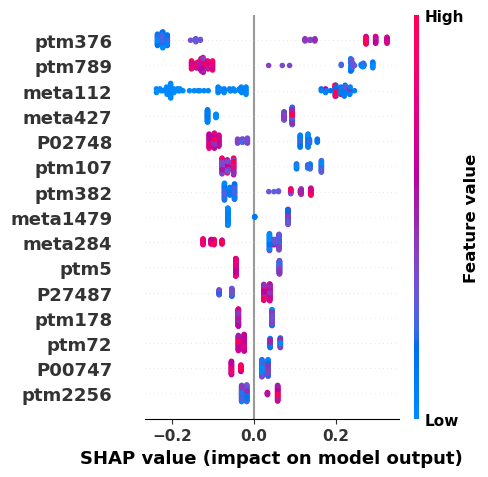

In [15]:
# 调整全局字体大小
plt.rcParams.update({
    'font.size': 14,          # 全局字体大小
    'font.weight': 'bold',    # 全局字体加粗
    'axes.labelweight': 'bold',  # 坐标轴标签加粗
    'axes.titleweight': 'bold'   # 标题加粗（如果有）
})

# 计算每个特征的平均绝对 SHAP 值
mean_shap_values = np.abs(shap_values_data_GBMXT).mean(axis=0)

# 获取最显著的15个特征
top_15_features_idx = np.argsort(mean_shap_values)[-15:]  # 获取最大 15 个的索引
top_15_features = data_shap.columns[top_15_features_idx]  # 获取对应的特征名称

# 选择最显著的 15 个特征的 SHAP 值
shap_values_top_15 = shap_values_data_GBMXT[:, top_15_features_idx]  # 只选择前 15 个特征的 SHAP 值
data_shap_top_15 = data_shap[top_15_features]  # 只选择前 15 个特征的原始数据

# 绘制最显著的 15 个特征的 SHAP 摘要图
shap.summary_plot(shap_values_top_15, data_shap_top_15, feature_names=top_15_features, plot_type="dot", show=False, plot_size=(5, 5))

# 保存并显示图表
plt.savefig('shap_plot_top_15_significant.png', dpi=300)
plt.show() 

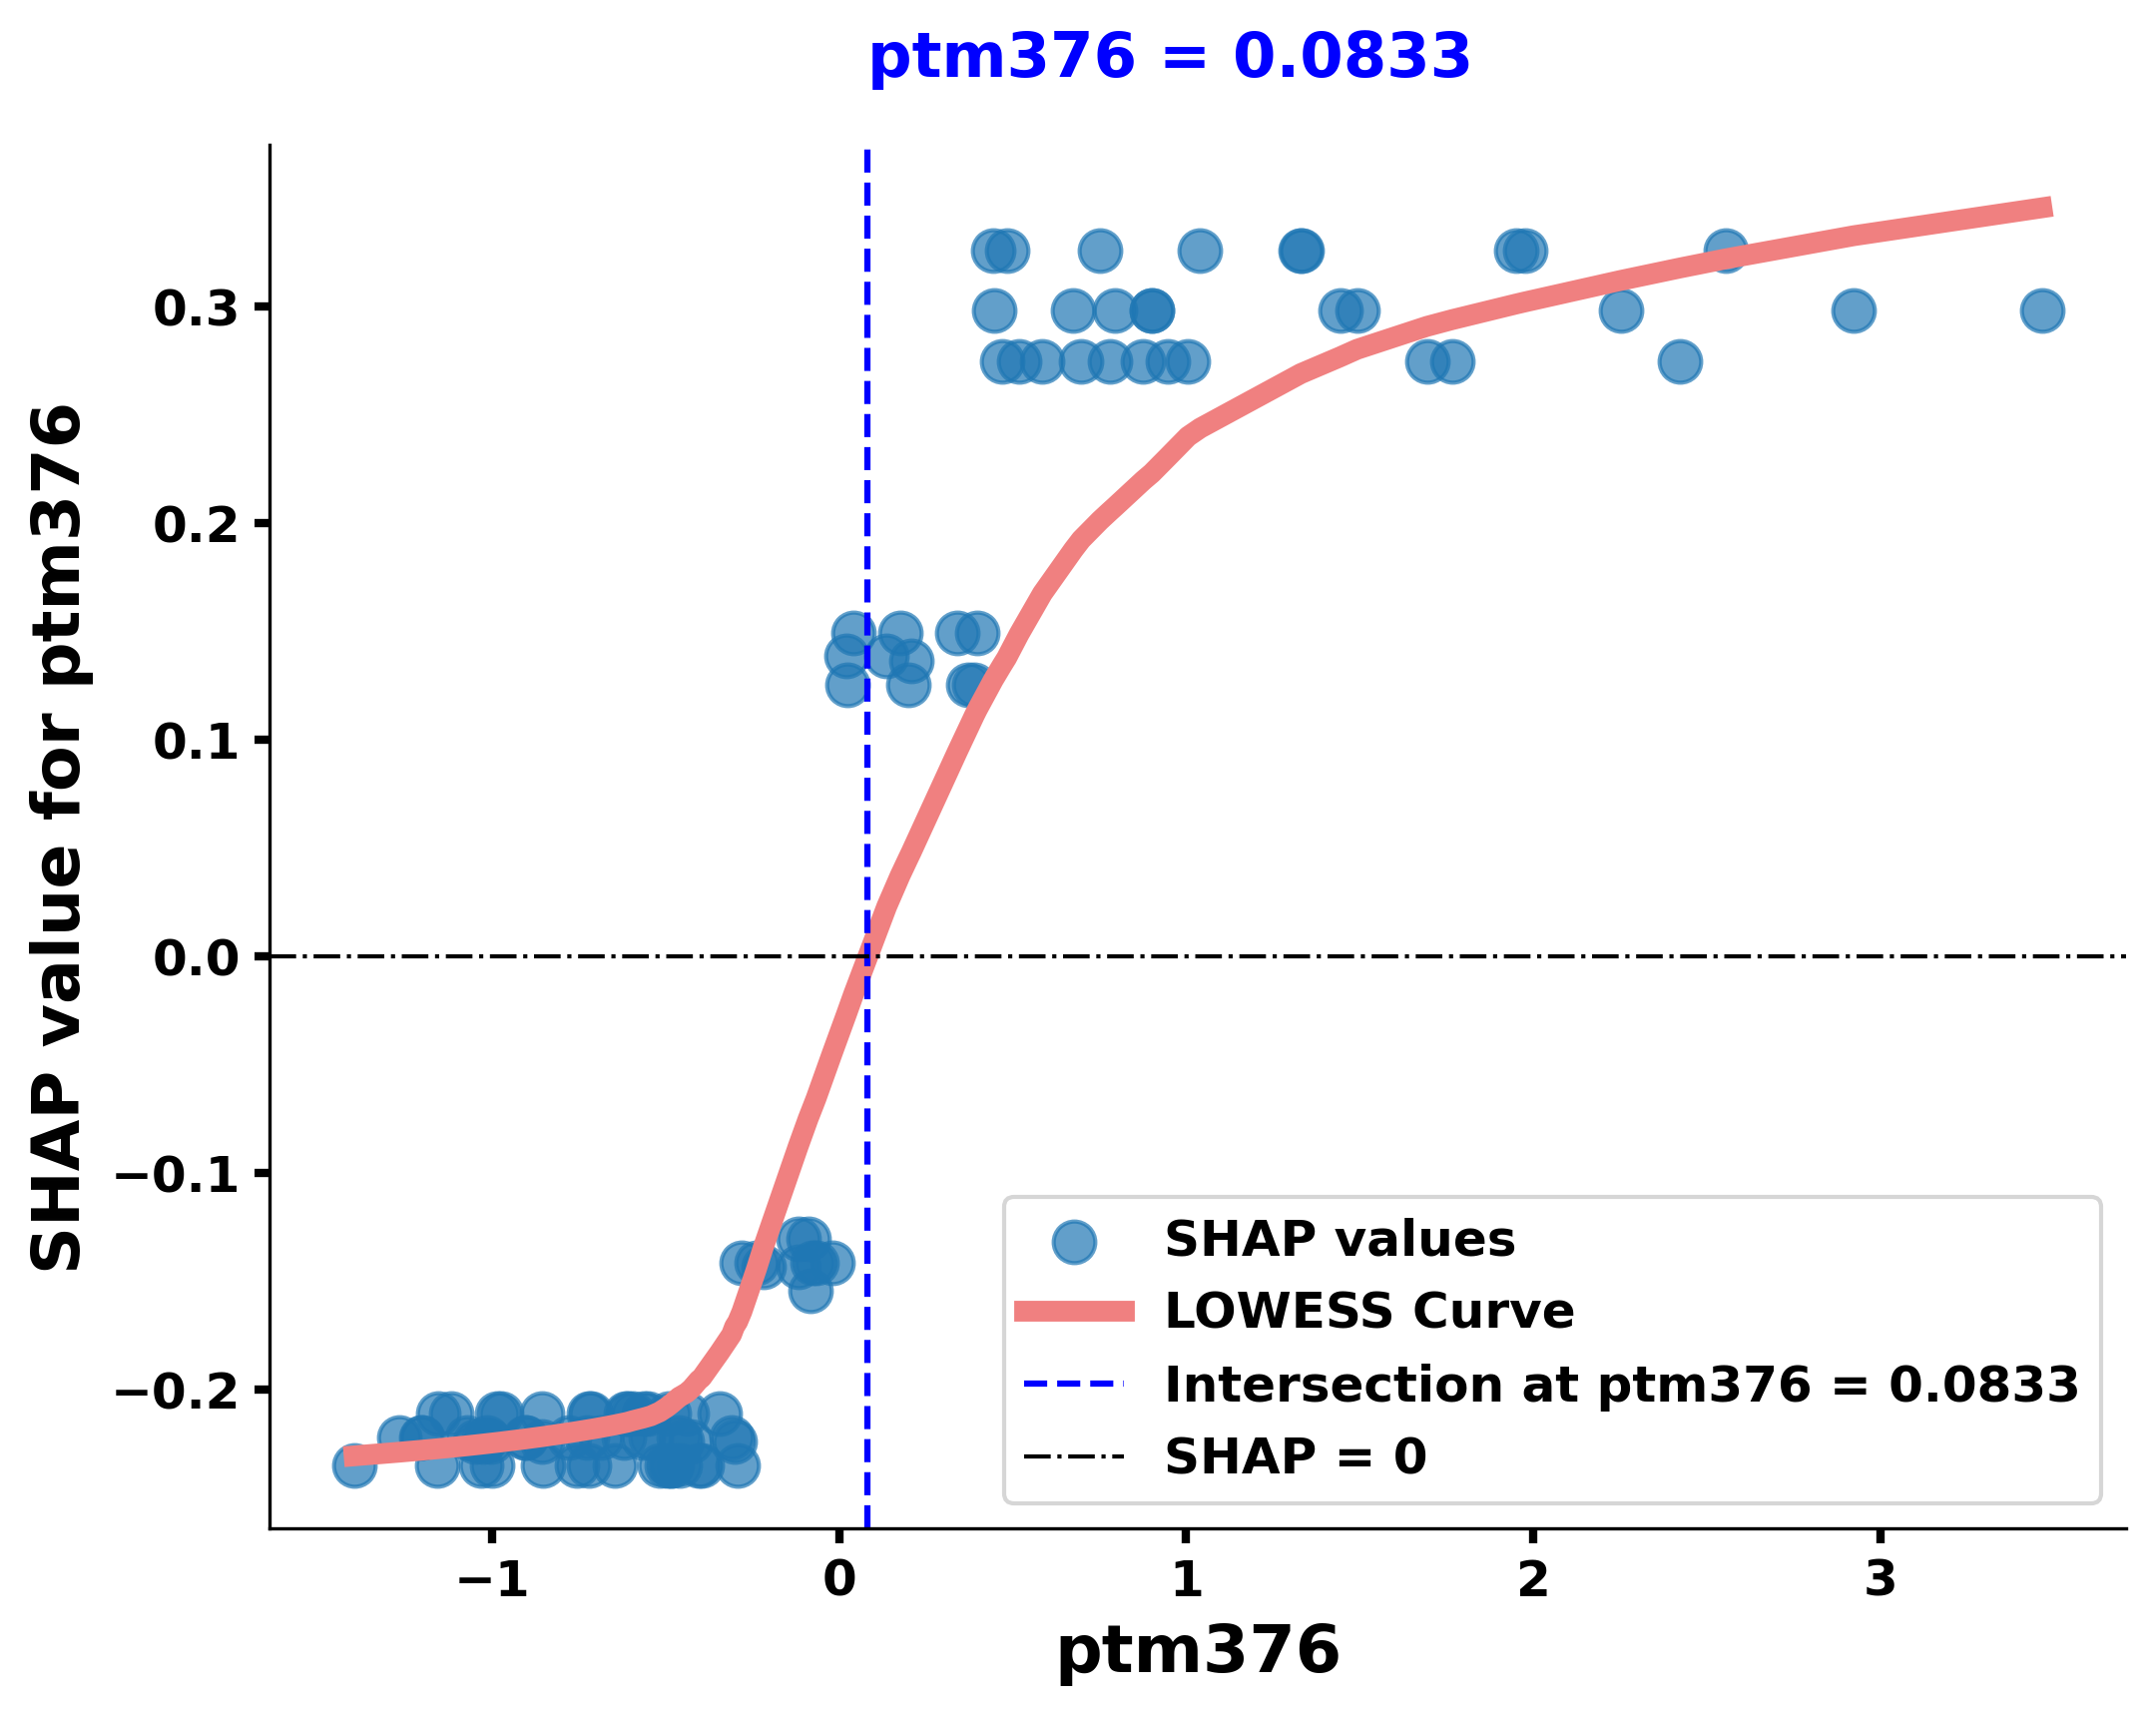

In [22]:
from scipy.optimize import fsolve

plt.rcParams.update({
    'font.size': 12,          # 全局字体大小
    'font.weight': 'bold',    # 全局字体加粗
    'axes.labelweight': 'bold',  # 坐标轴标签加粗
    'axes.titleweight': 'bold'   # 标题加粗（如果有）
})

# 绘制散点图
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(data['ptm376'], shap_values_df['ptm376'], s=100, label='SHAP values', alpha=0.7)

# 添加LOWESS拟合曲线
sns.regplot(x=data['ptm376'], y=shap_values_df['ptm376'], scatter=False, lowess=True, color='lightcoral', line_kws={'linewidth': 5}, label='LOWESS Curve')

# 使用 LOWESS 数据生成拟合曲线
lowess_data = sns.regplot(x=data['ptm376'], y=shap_values_df['ptm376'], scatter=False, lowess=True, color='lightcoral')
line = lowess_data.get_lines()[0]  # 拟合线条对象
x_fit = line.get_xdata()  # LOWESS 拟合线的 x 轴数据
y_fit = line.get_ydata()  # LOWESS 拟合线的 y 轴数据

# 找出所有与 y=0 相交的 x 值
def find_zero_crossings(x_fit, y_fit):
    crossings = []
    for i in range(1, len(y_fit)):
        if (y_fit[i-1] < 0 and y_fit[i] > 0) or (y_fit[i-1] > 0 and y_fit[i] < 0):
            # 使用插值法找到 x_fit 和 y_fit 中 y 值接近 0 的 x 值
            crossing = fsolve(lambda x: np.interp(x, x_fit, y_fit), x_fit[i])[0]
            crossings.append(crossing)
    return crossings

x_intercepts = find_zero_crossings(x_fit, y_fit)

# 在图中标注所有的 x_intercepts
for x_intercept in x_intercepts:
    plt.axvline(x=x_intercept, color='blue', linestyle='--', label=f'Intersection at ptm376 = {x_intercept:.4f}')
    plt.text(x_intercept, 0.4, f'ptm376 = {x_intercept:.4f}', color='blue', fontsize=15, verticalalignment='bottom', fontweight='bold')

# 添加shap=0的横线
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1, label='SHAP = 0')

# 添加图例
plt.legend()

# 设置标签和标题
plt.xlabel('ptm376', fontsize=16, fontweight="bold")
plt.ylabel('SHAP value for ptm376', fontsize=16, fontweight="bold")

# 加粗坐标轴刻度字体
plt.tick_params(axis='both', which='major', labelsize=12, width=2)  # 设置字体大小和加粗

# 去除上和右的边框线
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# 保存并显示图像
plt.savefig("ptm376_SHAP Dependence.png",dpi=300)
plt.show()

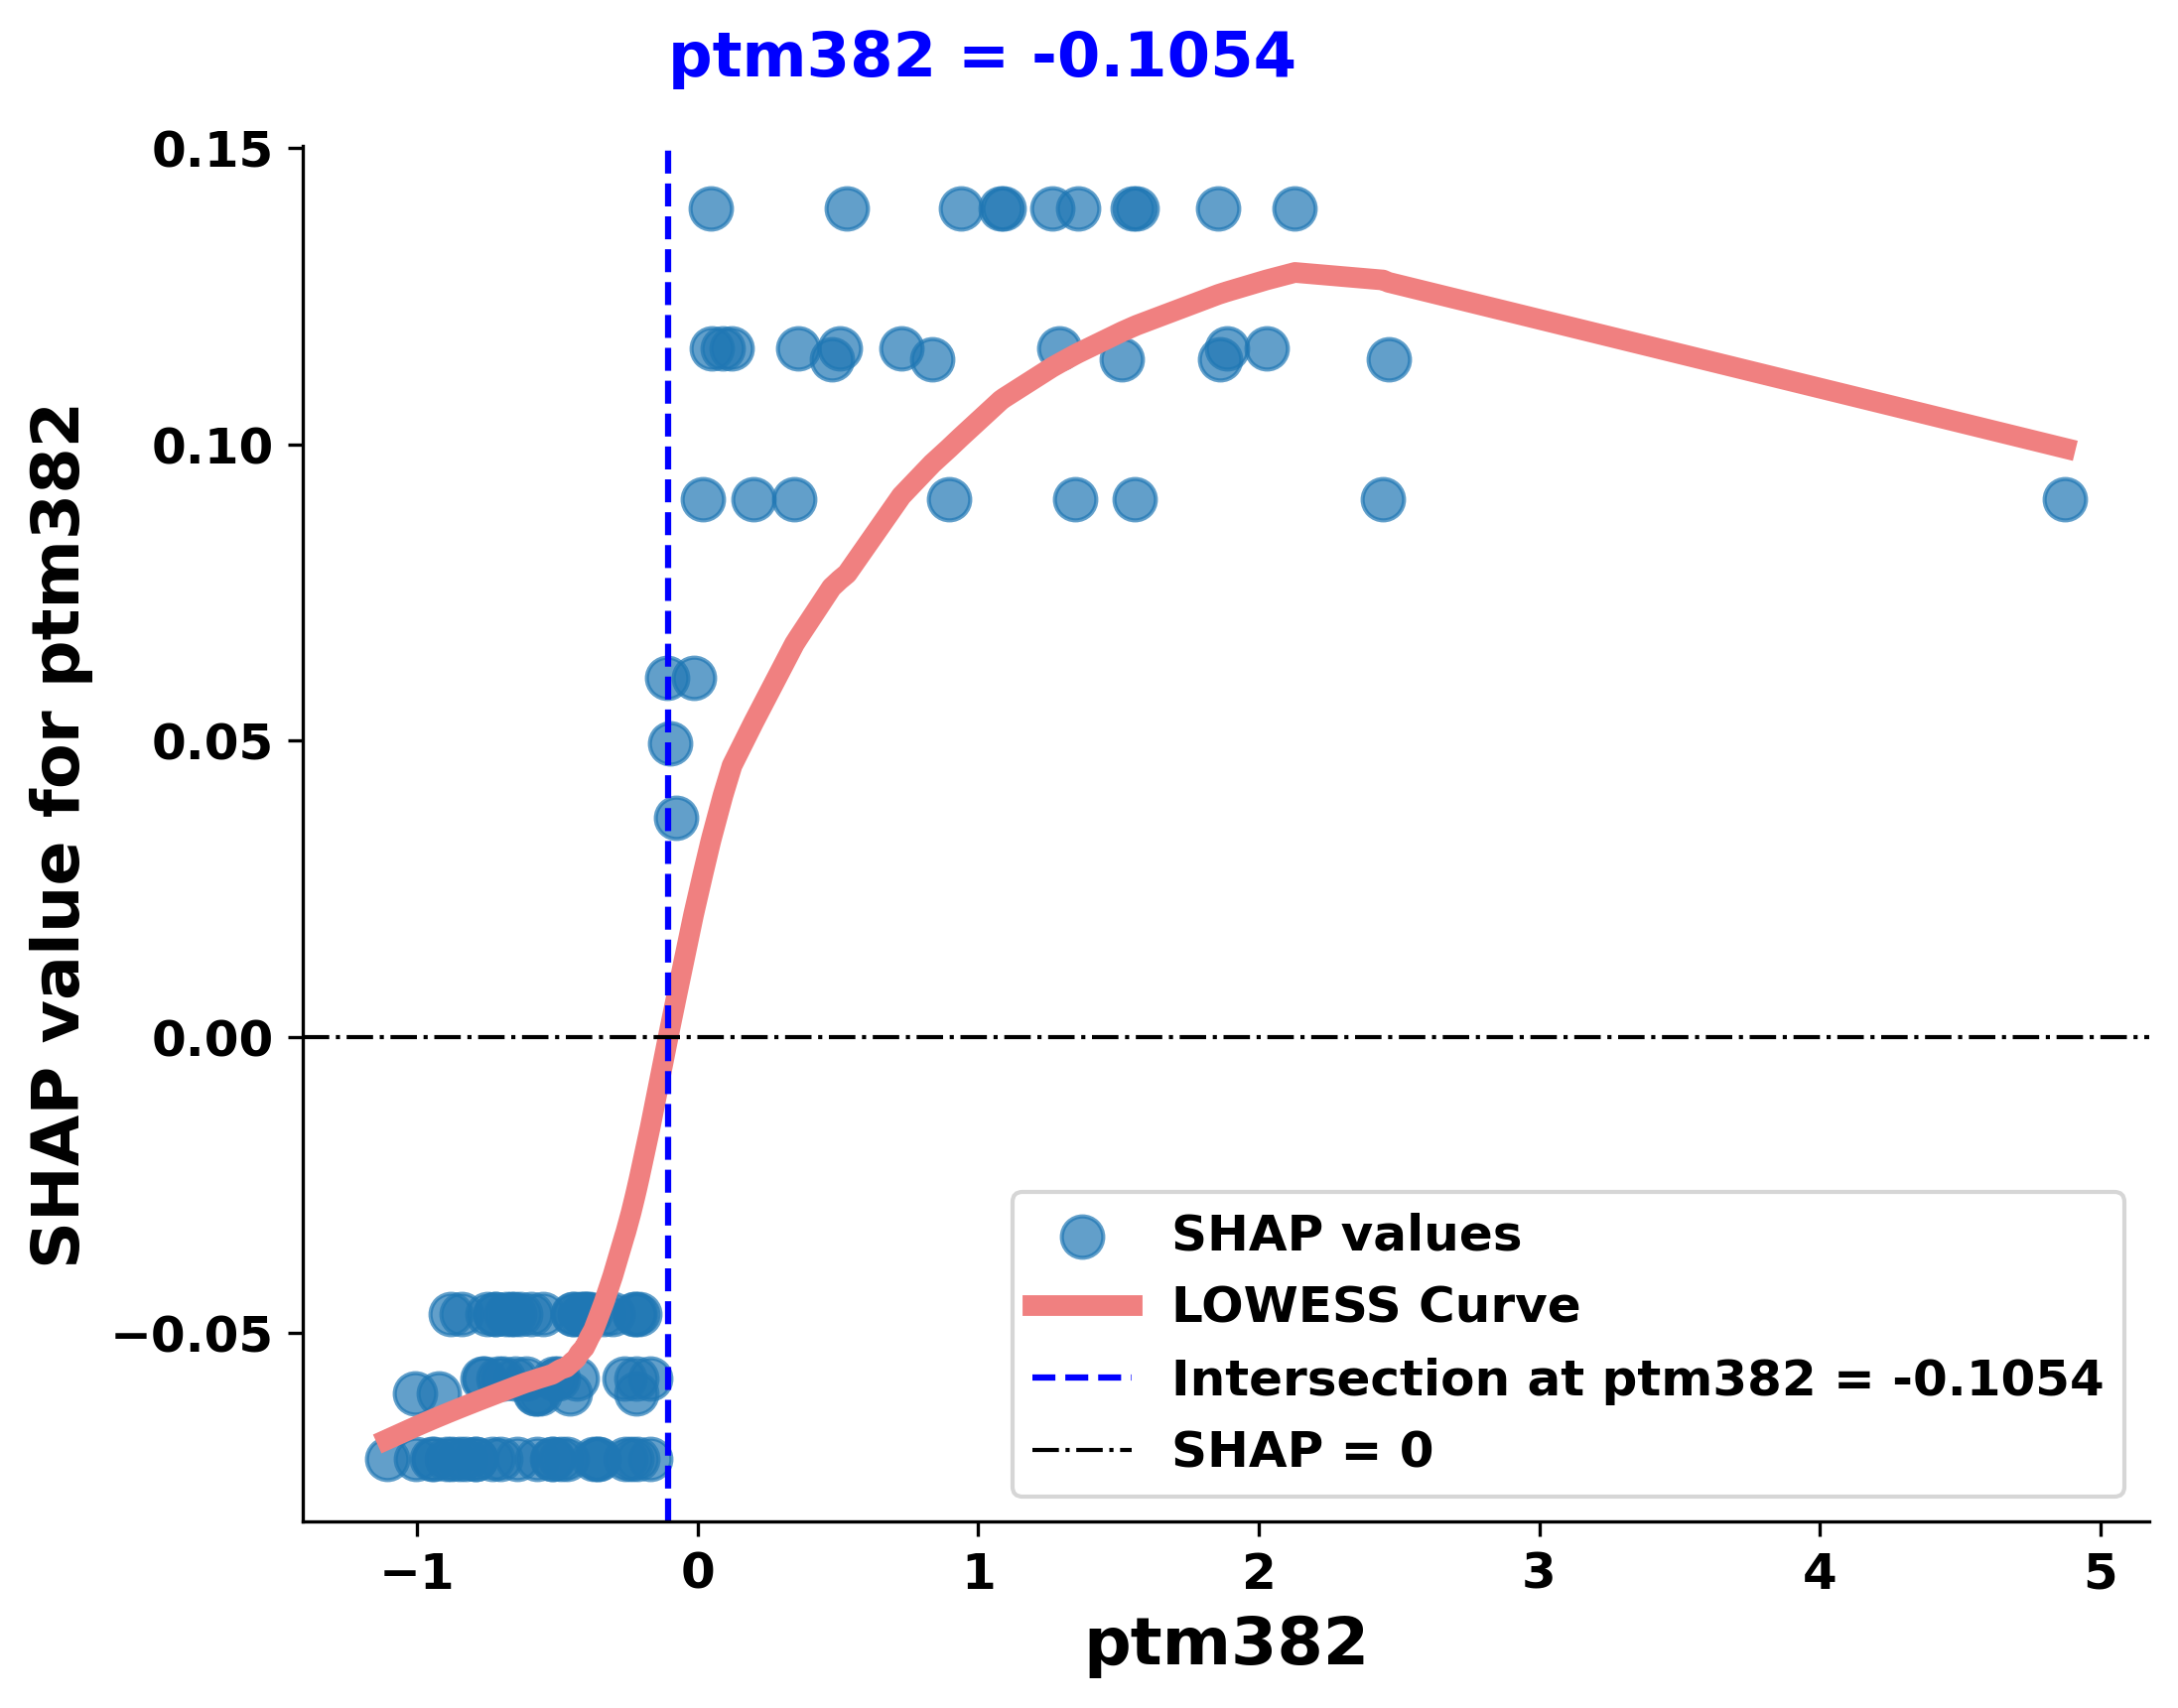

In [23]:
plt.rcParams.update({
    'font.size': 12,          # 全局字体大小
    'font.weight': 'bold',    # 全局字体加粗
    'axes.labelweight': 'bold',  # 坐标轴标签加粗
    'axes.titleweight': 'bold'   # 标题加粗（如果有）
})

# 绘制散点图
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(data['ptm382'], shap_values_df['ptm382'], s=100, label='SHAP values', alpha=0.7)

# 添加LOWESS拟合曲线
sns.regplot(x=data['ptm382'], y=shap_values_df['ptm382'], scatter=False, lowess=True, color='lightcoral', line_kws={'linewidth': 5}, label='LOWESS Curve')

# 使用 LOWESS 数据生成拟合曲线
lowess_data = sns.regplot(x=data['ptm382'], y=shap_values_df['ptm382'], scatter=False, lowess=True, color='lightcoral')
line = lowess_data.get_lines()[0]  # 拟合线条对象
x_fit = line.get_xdata()  # LOWESS 拟合线的 x 轴数据
y_fit = line.get_ydata()  # LOWESS 拟合线的 y 轴数据

# 找出所有与 y=0 相交的 x 值
def find_zero_crossings(x_fit, y_fit):
    crossings = []
    for i in range(1, len(y_fit)):
        if (y_fit[i-1] < 0 and y_fit[i] > 0) or (y_fit[i-1] > 0 and y_fit[i] < 0):
            # 使用插值法找到 x_fit 和 y_fit 中 y 值接近 0 的 x 值
            crossing = fsolve(lambda x: np.interp(x, x_fit, y_fit), x_fit[i])[0]
            crossings.append(crossing)
    return crossings

x_intercepts = find_zero_crossings(x_fit, y_fit)

# 在图中标注所有的 x_intercepts
for x_intercept in x_intercepts:
    plt.axvline(x=x_intercept, color='blue', linestyle='--', label=f'Intersection at ptm382 = {x_intercept:.4f}')
    plt.text(x_intercept, 0.16, f'ptm382 = {x_intercept:.4f}', color='blue', fontsize=15, verticalalignment='bottom', fontweight='bold')

# 添加shap=0的横线
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1, label='SHAP = 0')

# 添加图例
plt.legend()

# 设置标签和标题
plt.xlabel('ptm382', fontsize=16)
plt.ylabel('SHAP value for ptm382', fontsize=16)
# 去除上和右的边框线
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# 保存并显示图像
plt.savefig("ptm382_SHAP Dependence.png",dpi=300)
plt.show()

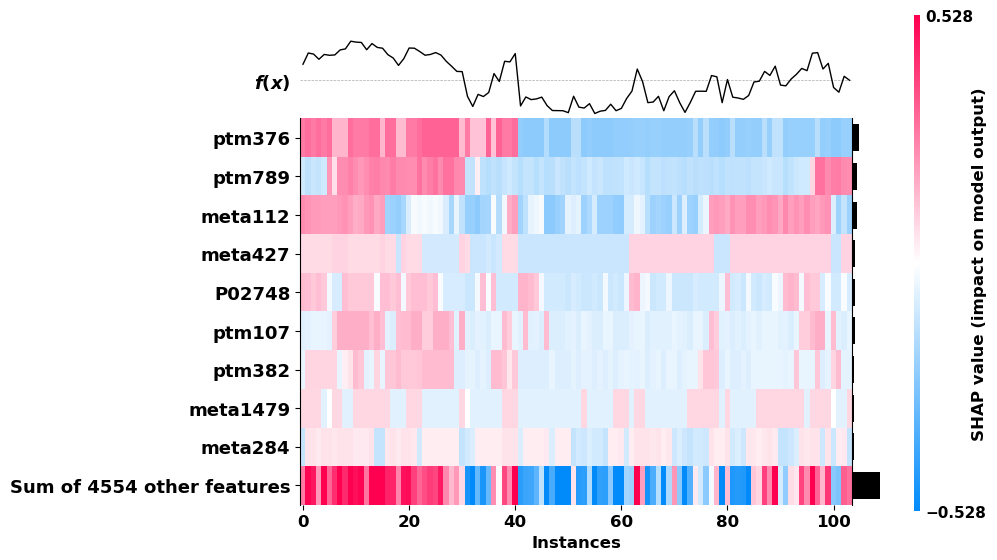

In [24]:
plt.rcParams.update({
    'font.size': 12,          # 全局字体大小
    'font.weight': 'bold',    # 全局字体加粗
    'axes.labelweight': 'bold',  # 坐标轴标签加粗
    'axes.titleweight': 'bold'   # 标题加粗（如果有）
})

# 绘制热图
plt.figure(figsize=(15, 8))
shap.plots.heatmap(explanation_data, show=False)
# 保存图像
plt.savefig('shap_heatmap.png', dpi=300, bbox_inches='tight')
# 确保图形已经绘制完成并渲染
plt.show()